# RNN Time Series example using Tensorflow
Justin Brandenburg, MapR Technologies

In [22]:
#What are we working with?
import sys
sys.version

'3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [23]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [24]:
#TF Version
tf.__version__

'1.0.1'

#### Generate some data

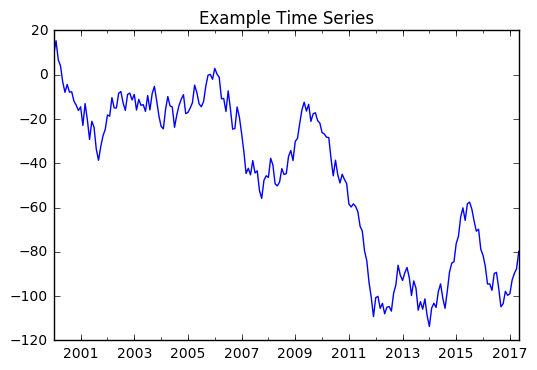

2000-01-31     9.459907
2000-02-29    15.333862
2000-03-31     6.712374
2000-04-30     3.990828
2000-05-31    -3.341279
2000-06-30    -7.932917
2000-07-31    -4.380528
2000-08-31    -7.867582
2000-09-30    -7.678637
2000-10-31   -11.893635
Freq: M, dtype: float64

In [73]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  Note the shape of the arrays. 

In [74]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

10
(10, 20, 1)
[[[  9.45990716]
  [ 15.33386214]
  [  6.71237381]
  [  3.99082793]
  [ -3.3412788 ]
  [ -7.93291687]
  [ -4.38052785]
  [ -7.86758207]
  [ -7.67863699]
  [-11.89363472]
  [-13.69998622]
  [-16.14347503]
  [-14.47510427]
  [-22.89621352]
  [-13.02399496]
  [-20.30929649]
  [-29.23297827]
  [-21.03236568]
  [-23.72978892]
  [-33.64032041]]

 [[-38.62292679]
  [-32.45610061]
  [-27.59971456]
  [-24.69683723]
  [-18.18395419]
  [-18.72744689]
  [-10.34940554]
  [-14.95633735]
  [-15.02343588]
  [ -8.43583867]
  [ -7.55887007]
  [-12.7620289 ]
  [-16.0889828 ]
  [ -8.87836987]
  [ -8.29846383]
  [-11.38304263]
  [ -8.90262955]
  [-15.94238896]
  [-11.1148985 ]
  [-13.83735967]]]
[[[ 15.33386214]
  [  6.71237381]
  [  3.99082793]
  [ -3.3412788 ]
  [ -7.93291687]
  [ -4.38052785]
  [ -7.86758207]
  [ -7.67863699]
  [-11.89363472]
  [-13.69998622]
  [-16.14347503]
  [-14.47510427]
  [-22.89621352]
  [-13.02399496]
  [-20.30929649]
  [-29.23297827]
  [-21.03236568]
  [-23.72978

#### Pull out our test data

In [75]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[ -66.06378071]
  [ -70.64374528]
  [ -69.77464756]
  [ -78.84581389]
  [ -81.55730718]
  [ -86.45367479]
  [ -94.50903422]
  [ -94.45531054]
  [ -97.33982342]
  [ -89.77619117]
  [ -89.2418552 ]
  [ -96.32521035]
  [-104.77615885]
  [-103.40328238]
  [ -97.81500242]
  [ -99.61218111]
  [ -98.91747746]
  [ -92.78987633]
  [ -89.75651817]
  [ -87.61022262]]]


In [76]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [77]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 724844.0
100 	MSE: 19297.0
200 	MSE: 10030.5
300 	MSE: 4453.94
400 	MSE: 2486.23
500 	MSE: 1849.27
600 	MSE: 1537.43
700 	MSE: 1365.78
800 	MSE: 1141.08
900 	MSE: 1062.75
[[[ -65.43389893]
  [ -70.15782166]
  [ -74.97548676]
  [ -76.0067215 ]
  [ -80.11599731]
  [ -87.79607391]
  [ -98.87727356]
  [-100.79344177]
  [ -96.78859711]
  [ -88.2572937 ]
  [ -89.33888245]
  [ -98.35159302]
  [-113.49594879]
  [-103.05888367]
  [ -92.25975037]
  [ -93.55337524]
  [-113.38123322]
  [-112.15855408]
  [ -85.15632629]
  [ -60.79482269]]]


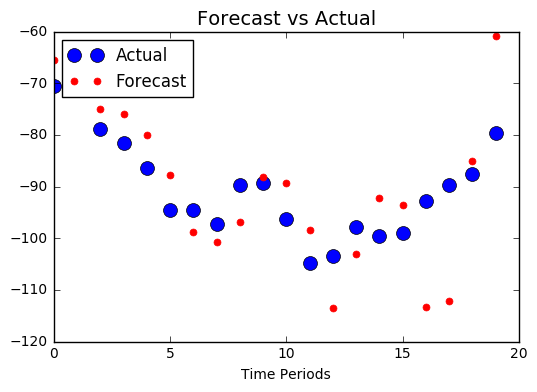

In [78]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

